# Рубежный контроль №2 Пронченко Т.А. ИУ5-62Б
Методы построения моделей машинного обучения.  
  
Задание. Для заданного набора данных (по Вашему варианту) постройте модели классификации или регрессии (в зависимости от конкретной задачи, рассматриваемой в наборе данных). Для построения моделей используйте методы 1 и 2 (по варианту для Вашей группы). Оцените качество моделей на основе подходящих метрик качества (не менее двух метрик). Какие метрики качества Вы использовали и почему? Какие выводы Вы можете сделать о качестве построенных моделей? Для построения моделей необходимо выполнить требуемую предобработку данных: заполнение пропусков, кодирование категориальных признаков, и т.д.  
  
Методы:1 - Метод опорных векторов, 2 - Случайный лес.  
Датасет: https://www.kaggle.com/datasets/san-francisco/sf-restaurant-scores-lives-standard

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

## 1. Загрузка данных
Используем датасет Boston Housing из CSV-файла.

In [23]:
# Загрузка CSV
df = pd.read_csv("restaurant-scores-lives-standard.csv")
df.head()


,business_id,business_name,business_address,business_city,business_state,business_postal_code,business_latitude,business_longitude,business_location,business_phone_number,...,inspection_type,violation_id,violation_description,risk_category,Neighborhoods (old),Police Districts,Supervisor Districts,Fire Prevention Districts,Zip Codes,Analysis Neighborhoods
0,101192,Cochinita #2,2 Marina Blvd Fort Mason,San Francisco,CA,NaN,NaN,NaN,NaN,1.415043e+10,...,New Ownership,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,97975,BREADBELLY,1408 Clement St,San Francisco,CA,94118,NaN,NaN,NaN,1.415724e+10,...,Routine - Unscheduled,97975_20190725_103124,Inadequately cleaned or sanitized food contact...,Moderate Risk,NaN,NaN,NaN,NaN,NaN,NaN
2,92982,Great Gold Restaurant,3161 24th St.,San Francisco,CA,94110,NaN,NaN,NaN,NaN,...,New Ownership,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,101389,HOMAGE,214 CALIFORNIA ST,San Francisco,CA,94111,NaN,NaN,NaN,1.415488e+10,...,New Construction,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,85986,Pronto Pizza,798 Eddy St,San Francisco,CA,94109,NaN,NaN,NaN,NaN,...,New Ownership,85986_20161011_103114,High risk vermin infestation,High Risk,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Предварительная обработка данных
Проверим пропуски, при необходимости заполним их.
В датасете нет категориальных признаков, все числовые.

In [24]:
columns_to_drop = [
    'business_id', 'business_name', 'business_address', 'business_city', 'business_state',
    'business_location', 'business_phone_number', 'violation_id', 'violation_description',
    'Neighborhoods (old)', 'Police Districts', 'Supervisor Districts',
    'Fire Prevention Districts', 'Zip Codes', 'Analysis Neighborhoods'
]
df = df.drop(columns=columns_to_drop)

# Удалим строки без оценки
df = df[df['inspection_score'].notnull()]

# Заполним пропуски
df['risk_category'] = df['risk_category'].fillna('Unknown')
df['business_postal_code'] = df['business_postal_code'].fillna('00000')
df['business_latitude'] = df['business_latitude'].fillna(df['business_latitude'].median())
df['business_longitude'] = df['business_longitude'].fillna(df['business_longitude'].median())

# Удалим ID и дату
df = df.drop(columns=['inspection_id', 'inspection_date'])
df.head()

,business_postal_code,business_latitude,business_longitude,inspection_score,inspection_type,risk_category
1,94118,37.780348,-122.419004,96.0,Routine - Unscheduled,Moderate Risk
7,94117,37.780348,-122.419004,84.0,Routine - Unscheduled,Moderate Risk
8,94103,37.780348,-122.419004,94.0,Routine - Unscheduled,Moderate Risk
11,94107,37.778634,-122.393089,71.0,Routine - Unscheduled,Low Risk
12,94108,37.780348,-122.419004,85.0,Routine - Unscheduled,Low Risk


## 3. Разделение на обучающую и тестовую выборки

In [4]:
X = df.drop('inspection_score', axis=1)
y = df['inspection_score']

numeric_features = ['business_latitude', 'business_longitude']
categorical_features = ['business_postal_code', 'inspection_type', 'risk_category']

In [5]:
# Делим на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 4. Масштабирование признаков
SVR чувствителен к масштабу, масштабируем данные.

In [6]:
# Пайплайн предобработки
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Модели
svr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

## 5. Обучение моделей

In [7]:
# Обучаем
svr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['business_latitude',
                                                   'business_longitude']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['business_postal_code',
                                                   'inspection_type',
                                                   'risk_category'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

## 6. Оценка качества моделей
Используем метрики:
- R² (коэффициент детерминации).
- MAE (Mean Absolute Error).
- RMSE (Root Mean Squared Error).

In [25]:
# Предсказания
y_pred_svr = svr_pipeline.predict(X_test)
y_pred_rf = rf_pipeline.predict(X_test)

def print_metrics(name, y_true, y_pred):
    print(f"\n📊 {name} Metrics:")
    print(f"MAE:  {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE: {root_mean_squared_error(y_true, y_pred):.2f}")
    print(f"R²:   {r2_score(y_true, y_pred):.2f}")

print_metrics("SVR", y_test, y_pred_svr)
print_metrics("Random Forest", y_test, y_pred_rf)


📊 SVR Metrics:
MAE:  5.53
RMSE: 7.52
R²:   0.19

📊 Random Forest Metrics:
MAE:  4.12
RMSE: 5.81
R²:   0.52


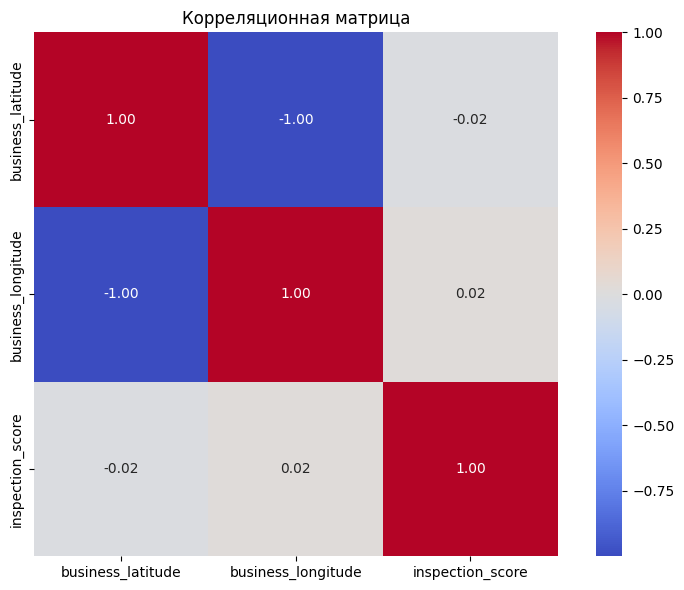

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Посчитаем корреляцию только по числовым признакам
corr_matrix = df.corr(numeric_only=True)

# Построим тепловую карту
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Корреляционная матрица")
plt.tight_layout()
plt.show()

## 7. Выводы
- **Почему выбраны эти метрики?**
  - R² показывает долю дисперсии, объясненную моделью.
  - MAE и RMSE дают представление о среднем размере ошибок в тех же единицах, что и целевая переменная.

- **Сравнение моделей:**
  - Если у одной модели выше R² и ниже MAE/RMSE, она лучше предсказывает.
  - Часто RMSE более чувствителен к крупным ошибкам, MAE — менее.

- **Рекомендации:**
  - Для данной задачи лучше всего себя показала модель случайный лес.
  - Для улучшения качества можно подобрать гиперпараметры, добавить новые признаки или использовать другие алгоритмы.